### DEMDP08 
# Public Renewable Resource Model

Welfare maximizing social planner must decide how much of a renewable resource to harvest.

- States
    -     s       quantity of stock available
- Actions
    -     q       quantity of stock harvested
- Parameters
    - $\alpha$     growth function parameter
    - $\beta$      growth function parameter
    - $\gamma$    relative risk aversion
    - $\kappa$     unit cost of harvest
    - $\delta$     discount factor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from compecon import BasisChebyshev, DPmodel, DPoptions, qnwnorm, demo

### Model parameters

In [2]:
α, β, γ, κ, δ = 4.0, 1.0, 0.5, 0.2, 0.9

### Steady-state

The steady-state values for this model are

In [3]:
sstar = (α**2 - 1/δ**2)/(2*β)     # steady-state stock
qstar = sstar - (δ*α-1)/(δ*β) # steady-state action

print('Steady-State')
print(f"\t{'Stock':12s} = {sstar:8.4f}")
print(f"\t{'Harvest':12s} = {qstar:8.4f}")

Steady-State
	Stock        =   7.3827
	Harvest      =   4.4938


## Numeric results

### State space
The state variable is s="Stock", which we restrict to $s\in[6, 9]$. 

Here, we represent it with a Chebyshev basis, with $n=8$ nodes.

In [4]:
n, smin, smax = 8, 6, 9
basis = BasisChebyshev(n, smin, smax, labels=['Stock'])

### Action space
The choice variable q="Harvest" must be nonnegative.

In [5]:
def bounds(s, i=None, j=None):
    return np.zeros_like(s), s[:]

### Reward function
The reward function is the utility of harvesting $q$ units.

In [6]:
def reward(s, q, i=None, j=None):
    u = (q**(1-γ))/(1-γ)-κ*q
    ux= q**(-γ)-κ
    uxx = -γ*q**(-γ-1)
    
    return u, ux, uxx

### State transition function
Next period, the stock will be equal that is $s' = \alpha (s-q) - 0.5\beta(s-q)^2$

In [7]:
def transition(s, q, i=None, j=None, in_=None, e=None):
    sq = s-q
    g = α*sq - 0.5*β*sq**2
    gx = -α + β*sq
    gxx = -β*np.ones_like(s)
    return g, gx, gxx

### Model structure
The value of wealth $s$ satisfies the Bellman equation
\begin{equation*}
V(s) = \max_q\left\{\frac{q^{1-\gamma}}{1-\gamma} -\kappa q + \delta V(s')  \right\}
\end{equation*}

To solve and simulate this model,use the CompEcon class `DPmodel`

In [8]:
model = DPmodel(basis, reward, transition, bounds,
                       x=['Harvest'],
                       discount=δ)

### Solving the model

Solving the growth model by collocation

In [9]:
S = model.solve()

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       1.4e+01    0.0000
   1       1.9e+01    0.0156
   2       3.7e-01    0.0313
   3       1.1e-03    0.0313
   4       1.5e-08    0.0313
   5       7.6e-14    0.0469
Elapsed Time =    0.05 Seconds


`DPmodel.solve` returns a pandas `DataFrame` with the following data:

In [10]:
S.head()

,Stock,value,resid,Harvest
Stock,,,,
6.000000,6.000000,32.985613,6.795958e-09,3.349254
6.037975,6.037975,32.998722,-1.561688e-09,3.379828
6.075949,6.075949,33.011736,-5.604697e-09,3.410456
6.113924,6.113924,33.024658,-6.686072e-09,3.441138
6.151899,6.151899,33.037489,-5.868451e-09,3.471872


We are also interested in the shadow price of wealth (the first derivative of the value function).

In [11]:
S['shadow price'] = model.Value(S['Stock'],1)

## Plotting the results

### Optimal Policy

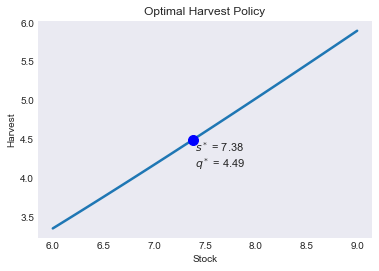

In [12]:
fig1 = demo.figure('Optimal Harvest Policy','Stock','Harvest')
plt.plot(S['Harvest'])
demo.annotate(sstar, qstar,f'$s^*$ = {sstar:.2f}\n$q^*$ = {qstar:.2f}','bo', (8, -8),ms=10,fs=11)

### Value Function

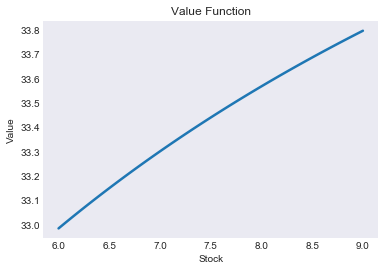

In [13]:
fig2 = demo.figure('Value Function', 'Stock', 'Value')
plt.plot(S.value)

### Shadow Price Function

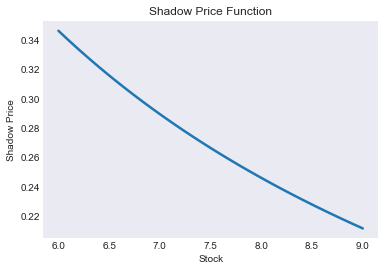

In [14]:
fig3 = demo.figure('Shadow Price Function', 'Stock', 'Shadow Price')
plt.plot(S['shadow price'])

### Residual

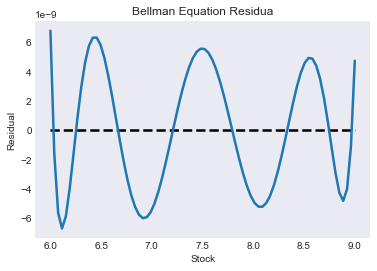

In [15]:
fig4 = demo.figure('Bellman Equation Residua', 'Stock', 'Residual')
plt.hlines(0,smin,smax,'k',linestyles='--')
plt.plot(S['resid'])
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

## Simulating the model

We simulate 16 periods of the model starting from $s=s_{\min}$

In [16]:
T = 16
data = model.simulate(T, smin)

### Simulated State and Policy Paths

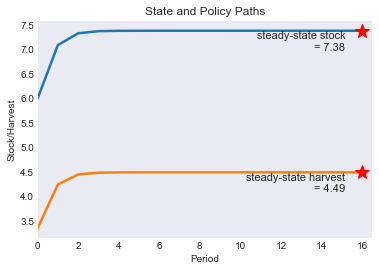

In [17]:
opts = dict(spec='r*', offset=(-5, -5), fs=11, ha='right')

fig5 = demo.figure('State and Policy Paths','Period', 'Stock/Harvest',[0, T + 0.5])
plt.plot(data[['Stock', 'Harvest']])
demo.annotate(T, sstar, f'steady-state stock\n = {sstar:.2f}', **opts)
demo.annotate(T, qstar, f'steady-state harvest\n = {qstar:.2f}', **opts)

In [18]:
#demo.savefig([fig1,fig2,fig3,fig4,fig5])